# Tree mobility plots

In [2]:
# import statements
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import sys
from matplotlib.lines import Line2D

In [3]:
# script parameters
genomes_per_species = 10 # minimal number of genomes per species
threshold_accessory = 0.9 # fraction of genomes per species an orthogroup can be present in at max. to be considered accessory
min_contigsize = 20 # minimal contig size to be able to detect MGEs
small_contig_threshold = 100 # contigs containing a number of genes >= 100 are considered small
running_average_default = 20 # default number of consecutive genes to take into account to calculate running averages
running_average_default_small_contigs = 5 # default number of consecutive genes to take into account to calculate running averages in small contigs
project_path = Path().resolve().parent
path_genomes = project_path / "data" / "genomes_metadata.csv"
path_mobility = project_path / "results" / "intermediate" / "mobility_frame.csv"
path_pangenome = project_path / "data" / "pangenome.tsv"
output_path_plots = project_path / "results" / "mobility_plots"
output_path_plots_2 = project_path / "results" / "tree_mobility_plots"
output_path_files = project_path / "results" / "mobility_files"


In [4]:
# import data
genomes = pd.read_csv(path_genomes).loc[:,'genome':'gtdb_species']
mobility_frame = pd.read_csv(path_mobility)
pangenome = pd.read_csv(path_pangenome, delimiter="\t", header=None)
pangenome.columns = ["gene", "genome", "orthogroup"]

In [5]:
def get_species(genomes, genome):
    """Returns the bacterial species to which a genome belongs, based on a genomes metadata file."""
    return genomes[genomes.genome==genome].gtdb_species.item()

In [6]:
def determine_order(pangenome):
    """Extracts contig and order information from the pangenome file."""
    order = pangenome["gene"].str.split("_", n=1, expand=True)
    order[1] = pd.to_numeric(order[1])
    order.columns = ["contig", "order"]
    full_order = order.merge(pangenome, left_index=True, right_index=True)
    return full_order


In [7]:
def get_nr_genes(full_order):
    """Counts the number of genes present per contig in a dataframe with columns 'contig' and 'gene'."""
    nr_genes = full_order.reindex(columns=["contig", "gene"]).drop_duplicates().groupby(by = "contig", as_index = False).count()
    nr_genes.columns = ["contig", "nr_genes"]
    return nr_genes

In [8]:
def get_size(full_order, contig):
    """Calculates the size of a contig of choice based on a dataframe with columns 'contig' and 'gene'."""
    nr_genes = get_nr_genes(full_order)
    return nr_genes.nr_genes[nr_genes.contig==contig].item()

In [9]:
def get_contigs(full_order, genome, filter_size=min_contigsize):
    """Returns the contigs belonging to a genome of choice, in a dataframe with columns 'contig' and 'gene', filtered to contain a minimal number of genes per contig."""
    contigs = pd.DataFrame()
    contigs['contig']=full_order.contig[full_order.genome==genome].drop_duplicates()
    contigs_size=contigs.merge(get_nr_genes(full_order), on='contig')
    contigs_final=contigs_size[(contigs_size.nr_genes)>=filter_size] # filter contigs: only contigs exceeding a size limit are retained
    return contigs_final.contig

In [10]:
def count_genomes_per_species(genomes):
    """Counts the number of genomes present per species present in a genomes metadata file."""
    counts = genomes.groupby(by="gtdb_species", as_index=False).count()
    counts.columns = ['gtdb_species', 'counts']
    return counts

In [11]:
def filter_species(genomes, filter_threshold=genomes_per_species):
    """Filters the species to contain a minimal number of genomes per species."""
    counts = count_genomes_per_species(genomes)
    genomes_filtered = pd.merge(genomes, counts[counts.counts >= filter_threshold], on='gtdb_species', how='right').sort_values('gtdb_species')
    return genomes_filtered

In [12]:
def get_scc(genomes, genome, full):
    """Calculates flags for orthogroups present in a genome of choice:
    whether or not this orthogroup is present as an accessory gene (represented by accessory==True), and whether or not this orthogroup is present as a single-copy gene (reprsented by 'count'==1). Returns a dataframe with columns 'orthogroup', 'count', 'accessory' and 'scc'. 'scc' is True when the orthogroup is accessory in this genome or when it is present in multiple copies.
    
    Args:
        genomes: Genomes metadata file
        genome: String representing the ID of the genome for which the mobility score needs to be plotted.
        full: Datafame containing pangenome information, filtered for relevant species.
    """
    
    species = get_species(genomes, genome)
    counts = count_genomes_per_species(genomes)
    full_species = full[full.gtdb_species==species]
    orthocounts_genomes_per_species = full_species.loc[:,["orthogroup","gtdb_species","genome"]].drop_duplicates().groupby(by = ["gtdb_species", "orthogroup"], as_index = False).count()
    orthocounts_genomes_per_species.columns = ["gtdb_species", "orthogroup", "orthocounts"]
    res = pd.merge(orthocounts_genomes_per_species, counts, on = 'gtdb_species', how = 'left')
    res.columns = ["gtdb_species", "orthogroup", "orthocounts", "genome_counts"]
    res['accessory'] = (res.orthocounts <= threshold_accessory * res.genome_counts)
    
    full_species = full[full.gtdb_species==species]
    orthocounts_genomes_per_species = full_species.loc[:,["orthogroup","gtdb_species","genome"]].drop_duplicates().groupby(by = ["gtdb_species", "orthogroup"], as_index = False).count()
    orthocounts_genomes_per_species.columns = ["gtdb_species", "orthogroup", "orthocounts"]
    res = pd.merge(orthocounts_genomes_per_species, counts, on = 'gtdb_species', how = 'left')
    res.columns = ["gtdb_species", "orthogroup", "orthocounts", "genome_counts"]
    res['accessory'] = (res.orthocounts <= threshold_accessory * res.genome_counts)
    
    full_genome = full.loc[full.genome==genome]
    genome_orthocounts = full_genome.loc[:,["orthogroup","gtdb_species"]].groupby(by = ["orthogroup"], as_index = False).count()
    genome_orthocounts.columns = ["orthogroup", "count"]
    
    core_copy = pd.merge(genome_orthocounts.loc[:,["orthogroup", "count"]], res.loc[:,["orthogroup", "accessory"]], on="orthogroup", how="left")
    d = {True: 'red', False: 'blue'}
    core_copy['scc']=(core_copy.accessory)|(core_copy['count']>1)
    core_copy.scc = core_copy.scc.map(d)
    
    return core_copy

In [25]:
def mobility_plots(genomes, genome, full, order, method="mobility_score", n=running_average_default, indicate_accessory=True):
    """Plots the mobility score across a genome of choice, according to a method of choice.
    
    Args:
        genomes: Genomes metadata file
        genome: String representing the ID of the genome for which the mobility score needs to be plotted.
        full: Datafame containing pangenome information, filtered for relevant species.
        order: Datafame containing information on the contig, and order of genes, and pangenome information.
        method: String representing the method used for calculating the mobility score. Options: "species_count", "genomes_count", "accessory_fraction".
        n: integer indicating the number of consecutive genes to take into account for a moving average calulation.
        indicate_accessory: Boolean indicating whether or not the plots need to be coloured based on accessory and copy number information of orthogroups.
    """
    for contig in get_contigs(order, genome):
        # a different number of consecutive genes is taken into account for small contigs
        if get_size(full_order, contig) <= small_contig_threshold:
            n=running_average_default_small_contigs
        scc=get_scc(genomes, genome, full)
        genome_order = order[(order.genome == genome)&(order.contig ==contig)].loc[:,["order", "orthogroup"]]
        mob_order = pd.merge(genome_order, mobility_frame, on="orthogroup", how="left").sort_values(by="order")
        mob_order_scc = pd.merge(mob_order, scc, on="orthogroup", how = "left")
        
        # plot 2
        print('Start plotting')
        fig, ax = plt.subplots(figsize=(30, 10))
        ax.plot(mob_order_scc.order, mob_order_scc['tree_score'].rolling(window=n, center=True).mean())
        # color points based on acesory and copy number information of orthogroups
        if indicate_accessory:
            ax.scatter(mob_order_scc.order, mob_order_scc['tree_score'].rolling(window=n, center=True).mean(), c=mob_order_scc.scc, marker='o')
        ax.set_xlabel("Gene position", fontsize=20)
        ax.set_ylabel("Mobility score", fontsize=20)
        ax.set_title(genome, fontsize=30)
        ax.tick_params(labelsize=18)
        legend_elements = [Line2D([0], [0], marker='o', color='blue', label='Single copy core'),
                   Line2D([0], [0], marker='o', color='red', label='Accessory and/or multi copy')]
        ax.legend(handles=legend_elements, fontsize=20)
        plt.show()
        return mob_order_scc
        #plt.savefig(output_path_plots_2 / str(genome+'-'+contig+'.png'))

In [ ]:
###
def mobility_file(order, genome, genomes, full):
    for contig in get_contigs(order, genome):
        scc=get_scc(genomes, genome, full)
        genome_order = order[(order.genome == genome)&(order.contig ==contig)].loc[:,["order", "orthogroup", "gene"]]
        mob_order = pd.merge(genome_order, mobility_frame.loc[:,["orthogroup", "accessory_fraction", "tree_score"]], on="orthogroup", how="left").sort_values(by="order")
        mob_order_scc = pd.merge(mob_order, scc.loc[:, ["orthogroup", "count", "accessory"]], on="orthogroup", how = "left")
        mob_order_scc.to_csv(output_path_files / str(genome+'-'+contig+'.csv'))

In [22]:
genomes_filtered = filter_species(genomes=genomes)
full = pd.merge(genomes_filtered, pangenome, on='genome', how='left')
full_order = determine_order(pangenome)


In [23]:
genome="GCA_900985785.1"

Start plotting


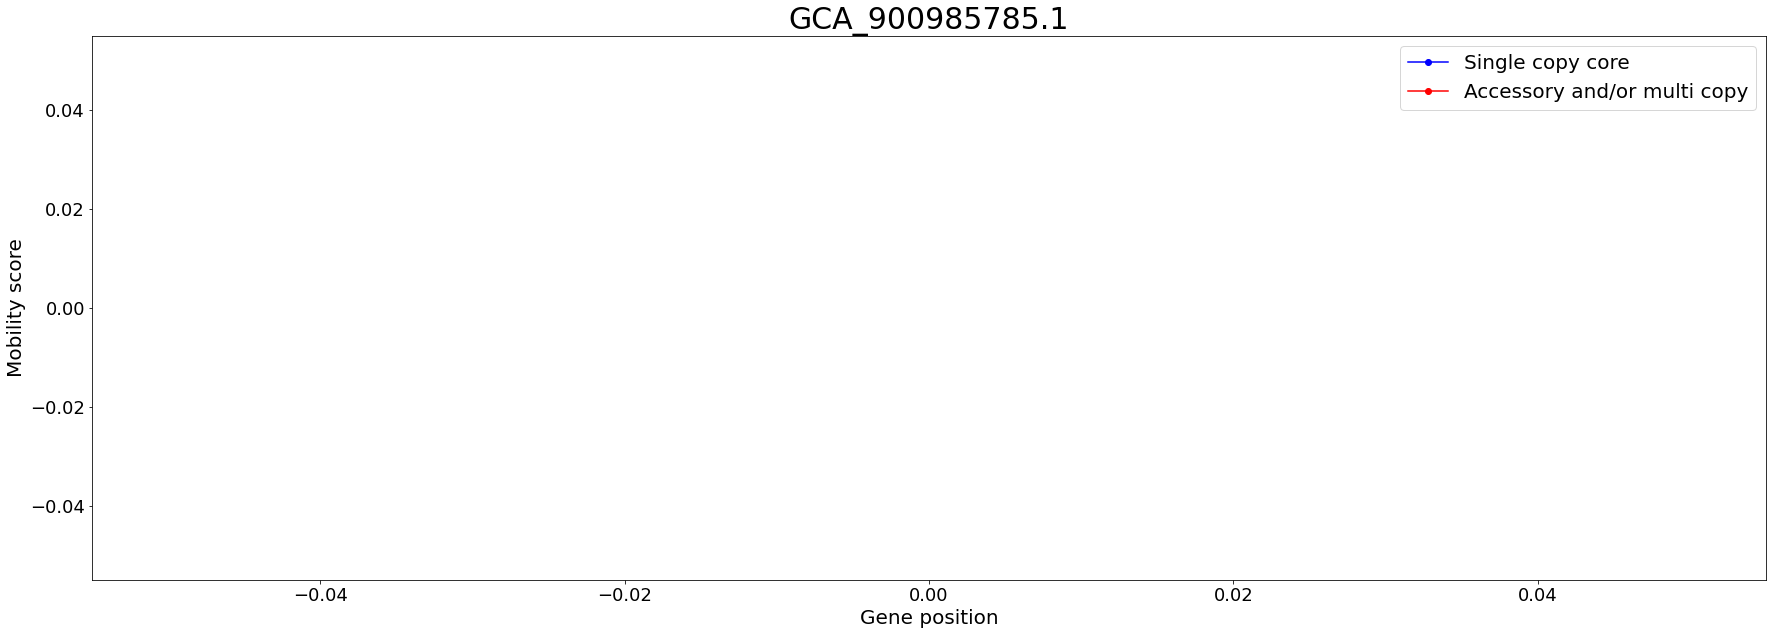

In [26]:
l=mobility_plots(genomes=genomes, genome=genome, full=full, order=full_order, method="accessory_fraction")
#mobility_file(order=full_order, genome=sys.argv[1], genomes=genomes, full=full)

In [28]:
l

,order,orthogroup,Unnamed: 0,Unnamed: 0.1,species_count,genomes_count,accessory_count,core_count,accessory_fraction,counts_mob,tree_score,count,accessory,scc
0,1,F04467_1,6737,6737,0.024390,0.000630,3.0,38.0,0.073171,0,NaN,2,False,red
1,2,F00558_4,1081,1081,0.012195,0.000328,1.0,81.0,0.012195,3056,0.919001,1,False,blue
2,3,F02074_7,3578,3578,0.012821,0.000336,0.0,78.0,0.000000,3056,0.833179,1,False,blue
3,4,F03928_5,6139,6139,0.018519,0.000498,2.0,52.0,0.037037,0,NaN,1,False,blue
4,5,F01345_1,2413,2413,0.016667,0.000470,5.0,55.0,0.083333,0,NaN,1,False,blue
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,229,F01514_4,2720,2720,0.015152,0.000391,5.0,61.0,0.075758,0,NaN,1,False,blue
229,230,F03493_5,5615,5615,0.012195,0.000328,0.0,82.0,0.000000,3056,0.929092,1,False,blue
230,231,F01105_4,2001,2001,0.012195,0.000329,0.0,82.0,0.000000,3056,0.935122,1,False,blue
231,232,F00962_2,1792,1792,0.012195,0.000329,1.0,81.0,0.012195,3056,0.940853,1,False,blue


In [31]:
sum(np.isnan(l.tree_score))

119

<function matplotlib.pyplot.show(close=None, block=None)>

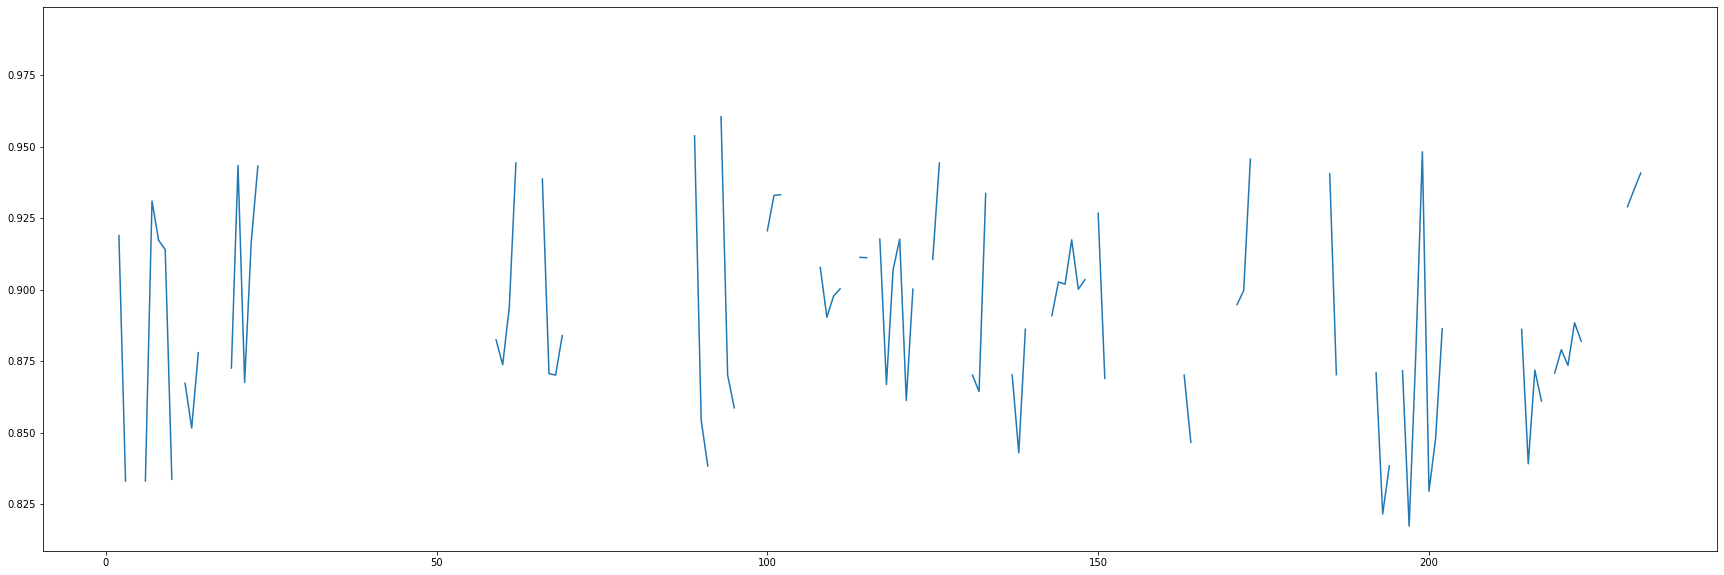

In [32]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.plot(l.order, l['tree_score'])
plt.show